## Tutorial: Fast self-forced trajectories

An essential component of the FastEMRIWaveforms (FEW) framework is the rapid evaluation of the inspiral trajectory of the secondary compact object. FEW provides the tools required for users to generate and visualiase these trajectories. Users can also implement their own trajectory models to incorporate additional physics (such as environmental effects or modifications to gravity). We will demonstrate these capabilities in this tutorial.

### ODE classes

#### Parameter conventions

FEW constructs trajectories by integrating the equations of motion of the compact binary; these are a system of ordinary differential equations (ODEs) that describe the evolution of the following parameters:

| Parameter    | Definition |
| :--------: | ------- |
| $p$  | (Dimensionless) semi-latus rectum|
| $e$ | Eccentricity |
| $x_I$    | Cosine of the inclination of the orbital plane|
| $\Phi_\phi$    | Azimuthal GW phase |
| $\Phi_\theta$    | Polar GW phase|
| $\Phi_r$    | Radial GW phase|

The ODE system can be integrated efficiently with adaptive Runge-Kutta techniques. These solvers obtain trajectories by integrating the right-hand side (RHS) of the ODE with respect to a time parameter.

#### Stock trajectory models

In order to handle the necessary information for evaluating the RHS of the ODE, FEW defines ODE classes. The following stock options are available:

| Model    | Features |  Notes |
| :--------: | ------- | ------- |
| KerrEqEccFlux | Adiabatic; equatorial eccentric inspiral with spinning primary| Our most up-to-date model |
| SchwarzEccFlux  | Adiabatic; inspiral with non-spinning primary | An older model (currently outdated) |
| PN5    | Post-Newtonian; eccentric inclined inspirals with spinning primary | Most complete model, but inaccurate for larger $e$ and/or lower $p$|


#### Obtaining the right-hand side of the trajectory ODE

As an example, let's examine the SchwarzEccFlux model:

In [1]:
from few.trajectory.ode import SchwarzEccFlux

rhs = SchwarzEccFlux()

Before evaluating the RHS, we must first define the parameters of the system that remain fixed during an inspiral. At adiabatic order, these are the initial masses of the primary ($m_1$), and secondary ($m_2$) and the dimensionless spin parameter of the primary ($a$):

In [2]:
m10 = 1e6  # Solar masses
m20 = 1e1  # Solar masses
a = 0.0  # For a Schwarzschild inspiral, the spin parameter is zero

rhs.add_fixed_parameters(m10, m20, a)

We can then access the ODE derivatives:

In [ ]:
p = 10.0
e = 0.3
xI = 1.0  # Schwarzschild inspiral is equatorial by definition

pdot, edot, xIdot, Phi_phi_dot, Phi_theta_dot, Phi_r_dot = rhs([p, e, xI])
pdot, edot, xIdot, Phi_phi_dot, Phi_theta_dot, Phi_r_dot

(-0.017771723696175704,
 -0.000779281500397855,
 0.0,
 0.028647063536752972,
 0.028647063536752972,
 0.018040932375307846)

FEW integrates trajectories on the radiation-reaction timescale $t_\mathrm{rr} = t \epsilon$, where $\epsilon = m_2 / m_1$ is the mass ratio of the system. The RHS of the ODE is therefore defined such that the $(\dot{p}, \dot{e}, \dot{x}_I)$ are scaled by $\epsilon^{-1}$. We can easily undo this rescaling if required:

In [ ]:
pdot, edot, xIdot, Phi_phi_dot, Phi_theta_dot, Phi_r_dot = rhs([p, e, xI], scale_by_eps=True)
pdot, edot, xIdot, Phi_phi_dot, Phi_theta_dot, Phi_r_dot

(-1.7771723696175706e-07,
 -7.792815003978551e-09,
 0.0,
 0.028647063536752972,
 0.028647063536752972,
 0.018040932375307846)

#### Checking the properties of an ODE system

The ODE class also defines a number of properties that describe the physical and systematic assumptions of the model:

In [ ]:
from few.trajectory.ode.base import get_ode_properties

get_ode_properties(rhs)

### Trajectory evaluation

#### The EMRIInspiral class

Trajectories are evaluated using the `EMRIInspiral` class, which interfaces with the underlying integrator classes and methods in order to integrate the trajectory from its initial conditions until either the maximum alloted duration elapses or pre-determined stopping conditions are satisfied.

The `EMRIInspiral` class offers a number of features that can be adjusted according to the desired output. We will demonstrate these below, working with the `KerrEccEqFlux` trajectory model as an example.

In [5]:
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux

In [6]:
# You can also instantiate this as EMRIInspiral(func="KerrEccEqFlux") to save an import.
traj_model = EMRIInspiral(func=KerrEccEqFlux)

In [7]:
m10 = 1e6
m20 = 1e2
a = 0.9  # This model supports a spinning primary compact object
p0 = 10.0
e0 = 0.8
xI0 = 1.0  # +1 for prograde, -1 for retrograde inspirals

traj_pars = [m10, m20, a, p0, e0, xI0]

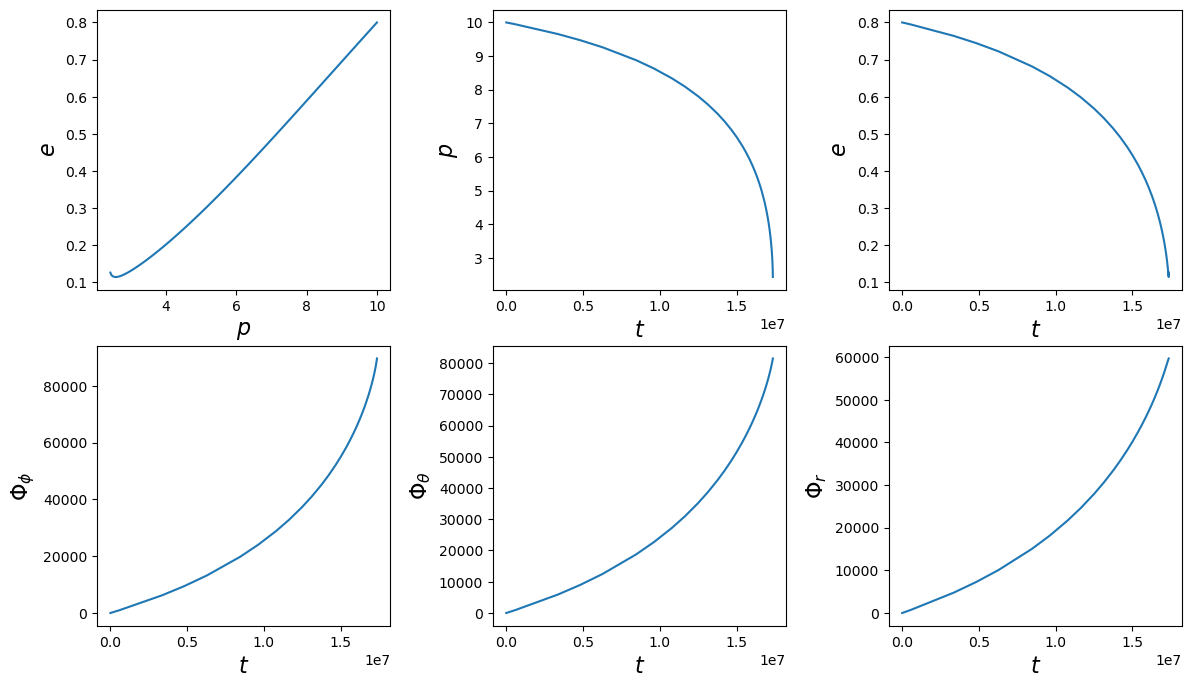

In [8]:
import matplotlib.pyplot as plt
import numpy as np

t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj_model(*traj_pars)

fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.35)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r"$e$", r"$p$", r"$e$", r"$\Phi_\phi$", r"$\Phi_\theta$", r"$\Phi_r$"]
xlabels = [r"$p$", r"$t$", r"$t$", r"$t$", r"$t$", r"$t$"]
ys = [e, p, e, Phi_phi, Phi_theta, Phi_r]
xs = [p, t, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

#### Trajectory stopping conditions

In principle, the inspiral trajectory continues until $p$ intersects with the separatrix, $p_\mathrm{sep}(a, e, x_I)$. However, FEW truncates the inspiral at the buffer point $p_\mathrm{stop} = p_\mathrm{sep} + \Delta p$ for numerical stability, performing a root-finding operation to place the last trajectory point within $\sim 10^{-8}$ of $p_\mathrm{stop}$. 

The size of $\Delta p$ can vary based on the trajectory model, and can be obtained directly from the ODE object:

In [9]:
from few.utils.utility import get_separatrix

Delta_p = KerrEccEqFlux().separatrix_buffer_dist
print("Delta_p:", Delta_p)
p_sep = get_separatrix(a, e[-1], xI[-1])  # the separatrix at the trajectory end-point.
p[-1] - (p_sep + Delta_p)

Delta_p: 0.002


1.4084533539460153e-08

#### Output for a requested time duration

By using the keyword argument `T`, the trajectory to be computed until it reaches a desired time (in years).

In [10]:
import matplotlib.pyplot as plt
import numpy as np

T = 0.1  # duration of trajectory in years (as defined by few.utils.constants.YRSID_SI)

t_trunc, p_trunc, e_trunc, xI_trunc, Phi_phi_trunc, Phi_theta_trunc, Phi_r_trunc = traj_model(*traj_pars, T=T)

t[-1], t_trunc[-1]

(17361118.902857028, 3155814.9763545603)

#### Output on a requested time grid

In addition to the sparse output of the adaptive solver, the user can also construct trajectories on pre-defined time grids. It is also possible to supply a sampling cadence $\mathrm{d}t$ and a uniform grid will be constructed automatically. Non-uniform grids can be supplied via the `new_t` keyword argument. In either case, the `fix_t` keyword argument can be used to truncate the returned trajectory before the separatrix.

t1 max: 19999900.0 t2 max: 17361100.0


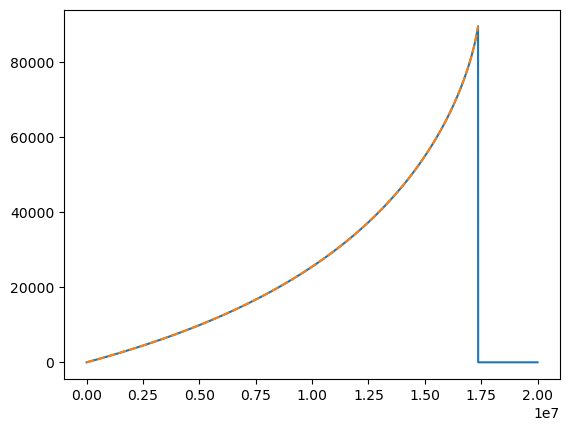

In [33]:
dt = 100.0
new_t = np.arange(0, 2e7, dt)

# A warning will be thrown if the new_t array goes beyond the time array output from the trajectory
t1, p1, e1, x1, Phi_phi1, Phi_theta1, Phi_r1 = traj_model(
    *traj_pars, new_t=new_t, upsample=True
)

# You can cut the excess on these arrays by setting fix_t to True
t2, p2, e2, x2, Phi_phi2, Phi_theta2, Phi_r2 = traj_model(
    *traj_pars, dt=dt, upsample=True, fix_t=True
)

plt.plot(t1, Phi_phi1)
plt.plot(t2, Phi_phi2, ls="--")

print("t1 max:", t1.max(), "t2 max:", t2.max())

#### Return trajectory in dimensionless time coordinates

Trajectories are returned in coordinate time by default, but may be obtained in dimensionless time units by passing `is_coordinate_time=False`:

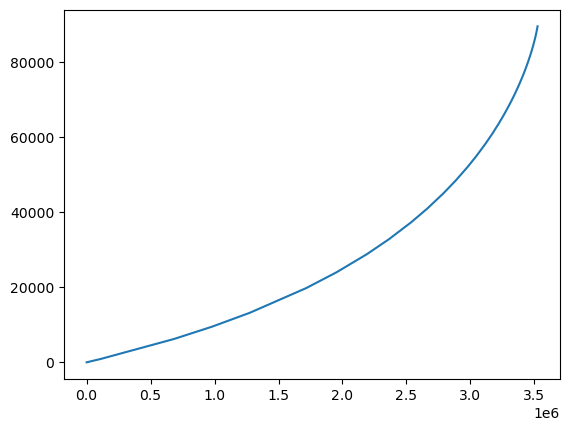

Dimensionless time step: 2.030254435033953


In [45]:
t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj_model(*traj_pars, in_coordinate_time=False)

plt.plot(t, Phi_phi)
plt.show()
print("Dimensionless time step:", t[1] - t[0])

#### Integrating trajectories with a fixed time-step

The adaptive stepping of the solver can be disabled with the `DENSE_STEPPING` keyword argument, which switches to taking uniform steps of size `dt`. This is more expensive and memory-intensive than adaptive stepping.

In [52]:
T_dense = 0.005

t_dense, p, e, x, Phi_phi, Phi_theta, Phi_r = traj_model(
    *traj_pars, T=T_dense, DENSE_STEPPING=True
)
t_adaptive, p, e, x, Phi_phi, Phi_theta, Phi_r = traj_model(*traj_pars, T=T_dense)
t_dense.shape, t_adaptive.shape

((15780,), (8,))

We can directly verify the accuracy of the adaptive solution by evaluating its output on the densely-stepped trajectory's time grid. The phase errors will be larger than the error in the orbital elements by a factor of $m_1 / m_2$ due to conventions chosen during integration:

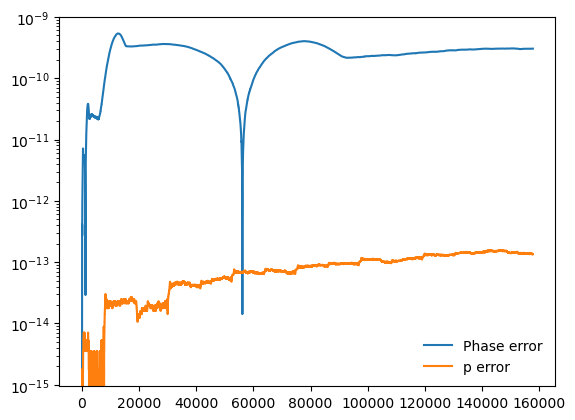

In [53]:
t_dense, p, e, x, Phi_phi, Phi_theta, Phi_r = traj_model(
    *traj_pars, T=T_dense, DENSE_STEPPING=True
)
t_adaptive, p_adaptive, e, x, Phi_phi_adaptive, Phi_theta, Phi_r = traj_model(
    *traj_pars, T=T_dense, new_t=t_dense, upsample=True
)

plt.semilogy(t_dense, abs(Phi_phi_adaptive - Phi_phi), label="Phase error")
plt.semilogy(t_dense, abs(p_adaptive - p), label="p error")
plt.legend(frameon=False)
plt.show()

#### Evolving trajectories backwards in time

Trajectories can also be evolved in reverse via the `integrate_backwards` keyword argument. Trajectories evolved in either direction will agree up to the numerical tolerance of the integrator:

3.127809122815961e-11

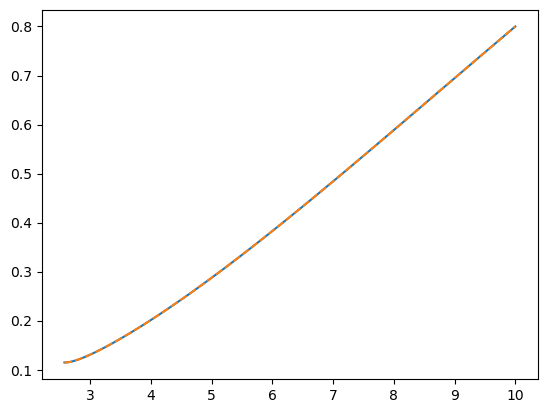

In [55]:
traj_pars_back = traj_pars.copy()

T = 0.55

# forward
t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj_model(*traj_pars, T=T)

traj_pars_back[3] = p[-1]
traj_pars_back[4] = e[-1]
traj_pars_back[5] = xI[-1]

# backward
t_back, p_back, e_back, xI_back, Phi_phi_back, Phi_theta_back, Phi_r_back = traj_model(
    *traj_pars_back, T=T, integrate_backwards=True
)

plt.plot(p, e)
plt.plot(p_back, e_back, ls="--")
p_back[-1] - p[0]

#### Setting the integrator error tolerance

The integrator tolerance (which is an absolute tolerance) can be adjusted by setting the `err` keyword argument. Higher error tolerances reduce the number of points in the trajectory, but at the cost of numerical accuracy. Note that `err` is a _local_ error tolerance, not a global one, and must therefore be set conservatively with respect to the desired global error tolerance. The default setting of $10^{-11}$ is a reasonable value and should not need to be changed for typical scenarios. 

In [56]:
p = traj_model(*traj_pars, T=T, err=1e-11)[1]
p_hightol = traj_model(*traj_pars, T=T, err=1e-9)[1]

p.size, p_hightol.size, (p[-1] - p_hightol[-1]).item()

(64, 39, -5.683401216316497e-08)

#### Integrating trajectories in $(E, L, Q)$ coordinates

Trajectories can also be solved in the constants of motion parameterisation $(E, L, Q)$ via the `integrate_constants_of_motion` keyword. This is supported for all stock trajectory models. Given input $(p_0, e_0, x_{I,0})$, the integrator converts these initial conditions to $(E, L, Q)$ and integrates these quantities alongside the inspiral phases. The output trajectory is converted back to $(p, e, x_I)$ coordinates if the keyword argument `convert_pex=True` (which it is by default).

Integrating in $(E, L, Q)$ can offer some advantages, especially near the separatrix (see [Hughes 2024](https://arxiv.org/abs/2401.09577) for more information). Typically the trajectory also consists of fewer points than its $(p, e, x_I)$ counterpart, and is therefore faster to compute. However, it can also be numerically unstable for very small eccentricities, where small errors in the constants of motion can be amplified when transformed back to $(p, e, x_I)$. Usage of this method should be considered somewhat experimental, especially for eccentric and inclined (generic) inspirals.

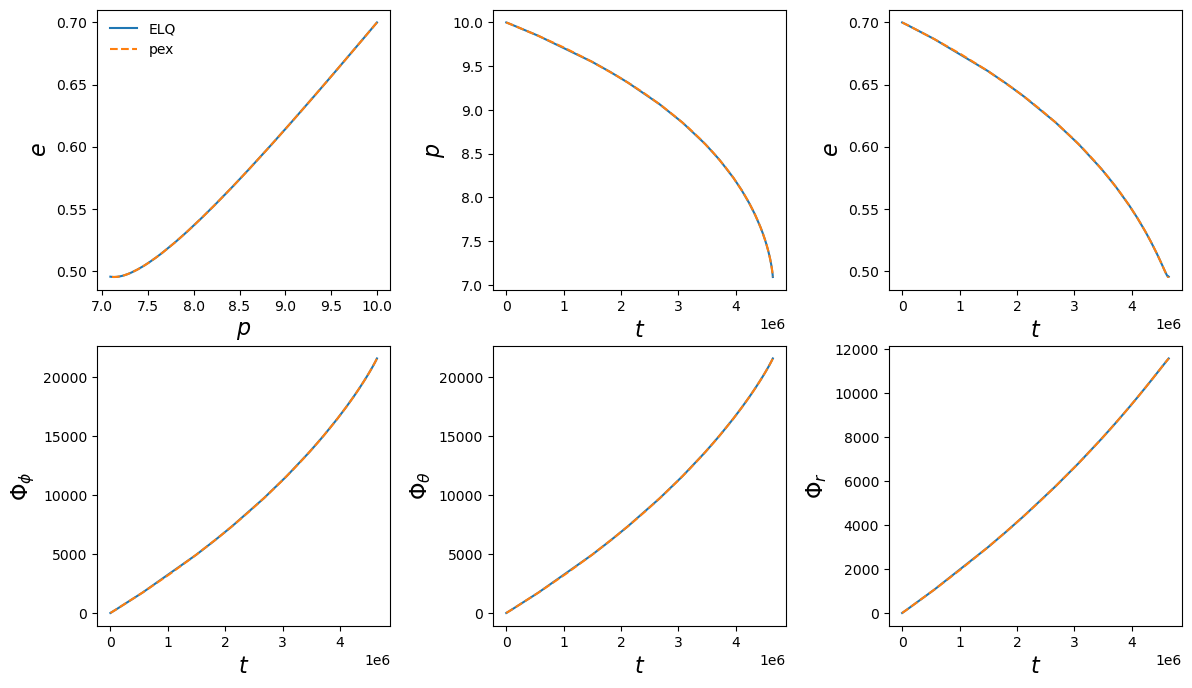

(ELQ, pex) trajectory lengths: [33, 50]
(ELQ, pex) phase difference: 0.0005484976463776547


In [61]:
m10 = 1e6
m20 = 1e2
a = 0.0
p0 = 10.0
e0 = 0.7
xI0 = 1.0
T = 1.0

traj_model_ELQ = EMRIInspiral(func=SchwarzEccFlux, integrate_constants_of_motion=True)
traj_model_pex = EMRIInspiral(func=SchwarzEccFlux, integrate_constants_of_motion=False)

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
plt.subplots_adjust(wspace=0.35)
axes = axes.ravel()
ylabels = [r"$e$", r"$p$", r"$e$", r"$\Phi_\phi$", r"$\Phi_\theta$", r"$\Phi_r$"]
xlabels = [r"$p$", r"$t$", r"$t$", r"$t$", r"$t$", r"$t$"]

lens = []
phase_ends = []
for traj_model, label, ls in zip(
    [traj_model_ELQ, traj_model_pex], ["ELQ", "pex"], ["-", "--"]
):
    t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj_model(m10, m20, a, p0, e0, xI0, T=T)

    # Plot the results for comparison
    ys = [e, p, e, Phi_phi, Phi_theta, Phi_r]
    xs = [p, t, t, t, t, t]

    for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
        ax.plot(x, y, label=label, ls=ls)
        ax.set_xlabel(xlab, fontsize=16)
        ax.set_ylabel(ylab, fontsize=16)

    lens.append(len(t))
    phase_ends.append(Phi_phi[-1])
axes[0].legend(frameon=False)

plt.show()

print("(ELQ, pex) trajectory lengths:", lens)
print("(ELQ, pex) phase difference:", phase_ends[1] - phase_ends[0])

### Trajectory-related utilities

#### Get $p_0$ based on desired duration of trajectory

If you have a desired length of trajectory to analyze, this function will give you the value of $p_0$ that corresponds to the proper evolution time.

In [104]:
from few.utils.utility import get_p_at_t

traj = EMRIInspiral(func=SchwarzEccFlux)

# Set initial parameters
m10 = 1e6
m20 = 5e1
a=0.0
e0 = 0.7
xI0=1.0

traj_args = [m10, m20, a, e0, xI0]
traj_kwargs = {}

t_out = 1.5
# Run trajectory
p0_new = get_p_at_t(
    traj,
    t_out,
    traj_args,
    #index_of_a=2, # specifies the position of the index as it appears in the argument of traj
    #index_of_p=3,
    #index_of_e=4,
    #index_of_x=5,
    traj_kwargs=traj_kwargs,
    xtol=1e-15,
    rtol=1e-15,
    bounds=None,
)

print(
    "p0_new = {} will create a waveform that is {} years long, given the other input parameters.".format(
        p0_new, t_out
    )
)

p0_new = 13.059789978708372 will create a waveform that is 1.5 years long, given the other input parameters.


#### Get $m_2$ based on desired duration of trajectory

Similarly, if you have a desired length of trajectory to analyze, this function will give you the value of $m_2$ that corresponds to the proper evolution time.

In [105]:
from few.utils.utility import get_mu_at_t

traj = EMRIInspiral(func=SchwarzEccFlux)

# Set initial parameters
m10 = 1e6
m20 = 5e1
a=0.0
e0 = 0.7
xI0=1.0

traj_args = [m10, 0.0, p0, e0, 1.0]
traj_kwargs = {}
index_of_mu = 1

t_out = 1.5
# Run trajectory
m20_new = get_mu_at_t(
    traj,
    t_out,
    traj_args,
    index_of_mu=index_of_mu,
    traj_kwargs=traj_kwargs,
    xtol=1e-15,
    rtol=1e-15,
    bounds=None,
)

print(
    "m20_new = {} will create a waveform that is {} years long, given the other input parameters.".format(
        m20_new, t_out
    )
)

m20_new = 100.3655241478979 will create a waveform that is 1.5 years long, given the other input parameters.


### User-defined trajectory models

In addition to FEW's built-in trajectory models, users can readily implement their own models in the same framework.
They can achieve this by:

- Subclassing the `ODEBase` base class,
  
- Defining the `evaluate_rhs` method, and
  
- Updating any relevant properties of the model (by default, they are set for generic Kerr inspirals).
  
You do not need to handle any boundary checking in your modified class (e.g., ensuring quantities remain physical) as this is performed automatically by the base class. 

#### Defining a new trajectory model


Let's implement a Post-Newtonian trajectory in Schwarzschild eccentric as an example

In [63]:
# Some elliptic functions for evaluating geodesic frequencies
from few.utils.elliptic import EllipK, EllipE, EllipPi

# Base classes
from few.trajectory.ode.base import ODEBase

# For common interface with C/mathematica
def Power(x, n):
    return x**n

def Sqrt(x):
    return np.sqrt(x)

# This class defines the right-hand side of the ODE
# We define the method "evaluate_rhs" according to our derivatives
# and set the "equatorial" and "background" properties accordingly
# We also set the "flux_output_convention" property to "pex" to tell
# the trajectory module what the RHS derivatives correspond to
class Schwarzschild_PN(ODEBase):
    @property
    def equatorial(self):
        return True

    @property
    def background(self):
        return "Schwarzschild"

    @property
    def flux_output_convention(self):
        return "pex"

    def evaluate_rhs(self, y):
        # Guard against bad integration steps
        p, e, xI = y[:3]

        # Perform elliptic calculations
        ellipE = EllipE(4 * e / (p - 6.0 + 2 * e))
        ellipK = EllipK(4 * e / (p - 6.0 + 2 * e))
        ellipPi1 = EllipPi(
            16 * e / (12.0 + 8 * e - 4 * e * e - 8 * p + p * p),
            4 * e / (p - 6.0 + 2 * e),
        )
        ellipPi2 = EllipPi(
            2 * e * (p - 4) / ((1.0 + e) * (p - 6.0 + 2 * e)), 4 * e / (p - 6.0 + 2 * e)
        )

        # Azimuthal frequency
        Omega_phi = (2 * Power(p, 1.5)) / (
            Sqrt(-4 * Power(e, 2) + Power(-2 + p, 2))
            * (
                8
                + (
                    (
                        -2
                        * ellipPi2
                        * (6 + 2 * e - p)
                        * (3 + Power(e, 2) - p)
                        * Power(p, 2)
                    )
                    / ((-1 + e) * Power(1 + e, 2))
                    - (ellipE * (-4 + p) * Power(p, 2) * (-6 + 2 * e + p))
                    / (-1 + Power(e, 2))
                    + (
                        ellipK
                        * Power(p, 2)
                        * (28 + 4 * Power(e, 2) - 12 * p + Power(p, 2))
                    )
                    / (-1 + Power(e, 2))
                    + (
                        4
                        * (-4 + p)
                        * p
                        * (2 * (1 + e) * ellipK + ellipPi2 * (-6 - 2 * e + p))
                    )
                    / (1 + e)
                    + 2
                    * Power(-4 + p, 2)
                    * (
                        ellipK * (-4 + p)
                        + (ellipPi1 * p * (-6 - 2 * e + p)) / (2 + 2 * e - p)
                    )
                )
                / (ellipK * Power(-4 + p, 2))
            )
        )

        # Post-Newtonian calculations
        yPN = pow(Omega_phi, 2.0 / 3.0)

        EdotPN = (
            (96 + 292 * Power(e, 2) + 37 * Power(e, 4))
            / (15.0 * Power(1 - Power(e, 2), 3.5))
            * pow(yPN, 5)
        )
        LdotPN = (
            (4 * (8 + 7 * Power(e, 2)))
            / (5.0 * Power(-1 + Power(e, 2), 2))
            * pow(yPN, 7.0 / 2.0)
        )

        # Flux
        Edot = -EdotPN
        Ldot = -LdotPN

        # Time derivatives
        pdot = (
            -2
            * (
                Edot
                * Sqrt((4 * Power(e, 2) - Power(-2 + p, 2)) / (3 + Power(e, 2) - p))
                * (3 + Power(e, 2) - p)
                * Power(p, 1.5)
                + Ldot * Power(-4 + p, 2) * Sqrt(-3 - Power(e, 2) + p)
            )
        ) / (4 * Power(e, 2) - Power(-6 + p, 2))

        edot = -(
            (
                Edot
                * Sqrt((4 * Power(e, 2) - Power(-2 + p, 2)) / (3 + Power(e, 2) - p))
                * Power(p, 1.5)
                * (
                    18
                    + 2 * Power(e, 4)
                    - 3 * Power(e, 2) * (-4 + p)
                    - 9 * p
                    + Power(p, 2)
                )
                + (-1 + Power(e, 2))
                * Ldot
                * Sqrt(-3 - Power(e, 2) + p)
                * (12 + 4 * Power(e, 2) - 8 * p + Power(p, 2))
            )
            / (e * (4 * Power(e, 2) - Power(-6 + p, 2)) * p)
        )

        xIdot = 0.0

        Phi_phi_dot = Omega_phi
        Phi_theta_dot = Omega_phi

        Phi_r_dot = (
            p * Sqrt((-6 + 2 * e + p) / (-4 * Power(e, 2) + Power(-2 + p, 2))) * np.pi
        ) / (
            8 * ellipK
            + (
                (-2 * ellipPi2 * (6 + 2 * e - p) * (3 + Power(e, 2) - p) * Power(p, 2))
                / ((-1 + e) * Power(1 + e, 2))
                - (ellipE * (-4 + p) * Power(p, 2) * (-6 + 2 * e + p))
                / (-1 + Power(e, 2))
                + (ellipK * Power(p, 2) * (28 + 4 * Power(e, 2) - 12 * p + Power(p, 2)))
                / (-1 + Power(e, 2))
                + (
                    4
                    * (-4 + p)
                    * p
                    * (2 * (1 + e) * ellipK + ellipPi2 * (-6 - 2 * e + p))
                )
                / (1 + e)
                + 2
                * Power(-4 + p, 2)
                * (
                    ellipK * (-4 + p)
                    + (ellipPi1 * p * (-6 - 2 * e + p)) / (2 + 2 * e - p)
                )
            )
            / Power(-4 + p, 2)
        )

        dydt = [pdot, edot, xIdot, Phi_phi_dot, Phi_theta_dot, Phi_r_dot]

        return dydt

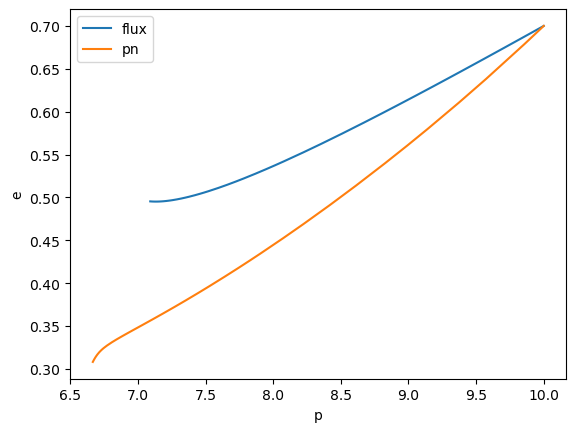

In [81]:
m10 = 1e6
m20 = 1e2
p0 = 10.0
e0 = 0.7
a = 0.0
xI0 = 1.0
T = 1.0

traj = EMRIInspiral(func=SchwarzEccFlux)
flux = traj(m10, m20, a, p0, e0, xI0, T=T, dt=10.0)
p,e = flux[1:3]

traj_PN = EMRIInspiral(func=Schwarzschild_PN)
flux_PN = traj_PN(m10, m20, a, p0, e0, xI0, T=T, dt=10.0)
p_PN, e_PN = flux_PN[1:3]

plt.plot(p, e, label="flux")
plt.plot(p_PN, e_PN, label="pn")
plt.ylabel("e")
plt.xlabel("p")

plt.legend()
plt.show()

#### Modifying an existing trajectory model

In cases where the desired trajectory model can be expressed as a function of one that is supported out-of-the-box, the inbuilt model can be subclassed and supplemented as required by defining the `modify_rhs` method. This method takes as input the
current system state and the corresponding derivatives produced by the model, which can then be modified as required. 

This method does not support a return argument for efficiency; the content of the first argument `derivs` should be modified in-place.

In [96]:
from few.trajectory.ode.flux import KerrEccEqFlux


class ModifiedKerrEccEqFlux(KerrEccEqFlux):
    def modify_rhs(self, ydot, y):
        # In-place modification of the derivatives
        ydot[0] *= 1 + self.additional_args[0]

m10 = 1e6
m20 = 1e2
a = 0.7
p = 10.0
e = 0.3
xI = 1.0

additional_args = [
    0.01,
]

# Example usage
original_ode = KerrEccEqFlux()
original_ode.add_fixed_parameters(m10, m20, a)

modified_ode = ModifiedKerrEccEqFlux()
modified_ode.add_fixed_parameters(m10, m20, a, additional_args)

original_ode([p, e, xI])[0], modified_ode([p, e, xI])[0]

(-0.011514135700755962, -0.011629277057763522)

#### Passing additional arguments to a modified trajectory model

When calling a trajectory, the `additional_args` attribute of the ODE class will be populated with any positional arguments following $x_I$:

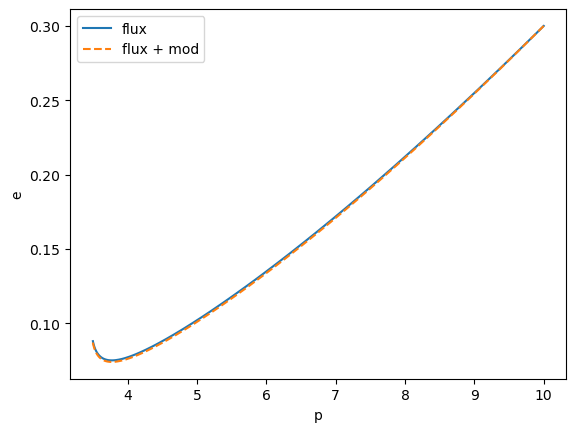

In [139]:
m10 = 1e6
m20 = 1e2
a = 0.7
p0 = 10.0
e0 = 0.3
xI0 = 1.0

traj_modified = EMRIInspiral(func=ModifiedKerrEccEqFlux)
flux_modified = traj_modified(m10, m20, a, p0, e0, xI0, 0.01, T=T, dt=10.0)

traj = EMRIInspiral(func=KerrEccEqFlux)
flux = traj(m10, m20, a, p0, e0, xI0, T=T, dt=10.0)

plt.plot(flux_modified[1], flux_modified[2], label="flux")
plt.plot(flux[1], flux[2], label="flux + mod", ls="--")
plt.ylabel("e")
plt.xlabel("p")

plt.legend()
plt.show()

The flux-based stock models perform interpolation to obtain the integral fluxes $\dot{E}$, $\dot{L}_{z}$, and then apply a Jacobian transformation in order to obtain $\dot{p}$, $\dot{e}$ if these are the variables of integration (and they are by default). In some cases, the user may wish to adjust $\dot{E}$, $\dot{L}_z$ directly if the modifications desired are more easily computed in this parameterisation. This can be achieved similarly to what was shown above, but with the `modify_rhs_before_Jacobian` method:

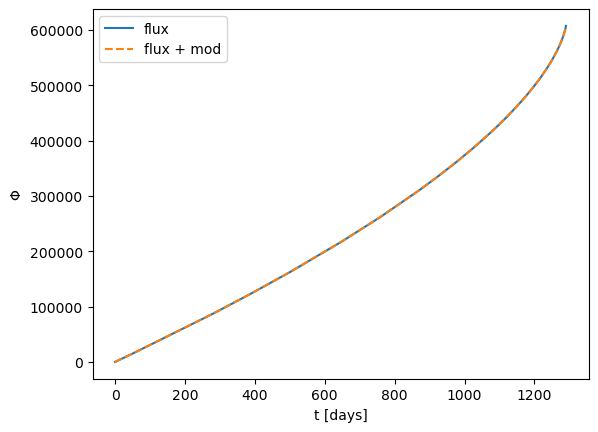

In [140]:
# A physically-motivated example: dissipation of energy and angular momentum due to dynamical friction with an accretion disk
# Modify the angular momentum derivative according to Eq(2.2) of https://dx.doi.org/10.1103/PhysRevX.13.021035
class KerrEccEqFluxAccretionDisk(KerrEccEqFlux):
    def modify_rhs(self, ydot, y):
        # In-place modification of the derivatives
        LdotAcc = (
            self.additional_args[0]
            * pow(y[0] / 10.0, self.additional_args[1])
            * 32.0
            / 5.0
            * pow(y[0], -7.0 / 2.0)
        )
        dL_dp = (
            -3 * pow(a, 3)
            + pow(a, 2) * (8 - 3 * y[0]) * np.sqrt(y[0])
            + (-6 + y[0]) * pow(y[0], 2.5)
            + 3 * a * y[0] * (-2 + 3 * y[0])
        ) / (2.0 * pow(2 * a + (-3 + y[0]) * np.sqrt(y[0]), 1.5) * pow(y[0], 1.75))
        # Transform back to pdot from Ldot abd add GW contribution
        ydot[0] = ydot[0] + LdotAcc / dL_dp



m10 = 1e6
m20 = 5e1
a = 0.9
p0 = 15.0
# Assume circular orbits, for extension to eccentricity see https://arxiv.org/pdf/2411.03436
e0 = 0.0
xI0 = 1.0
T = 4.0

traj = EMRIInspiral(func=KerrEccEqFlux, integrate_constants_of_motion=False)
flux = traj(m10, m20, a, p0, e0, xI0, T=T, dt=2.0)

traj_accretionDisk = EMRIInspiral(func=KerrEccEqFluxAccretionDisk, integrate_constants_of_motion=False)
flux_accretionDisk = traj_accretionDisk(m10, m20, a, p0, e0, xI0, 0.0, 8.0, T=T, dt=2.0)

plt.plot(flux[0] / 86400, flux[4], label="flux")
plt.plot(flux_accretionDisk[0] / 86400, flux_accretionDisk[4], label="flux + mod", ls="--")
plt.ylabel(r"$\Phi$")
plt.xlabel("t [days]")

plt.legend()
plt.show()

In [103]:
# Some nice italian-style plotting
!pip install pastamarkers

In [141]:
# Interpolate and compare the two trajectories
from scipy.interpolate import interp1d
from few.utils.utility import get_p_at_t
from few.utils.constants import YRSID_SI
from pastamarkers import markers
import time

traj_args = [m10, m20, a, e0, xI0]
traj_kwargs = {}
t_out = 1.5
results = {"orange": [], "blue": []}
for A, n, marker, col in zip(
    [0.4e-5, 0.1e-5],
    [59 / 10, 8.0],
    [markers.tortellini, markers.ravioli],
    ["orange", "blue"],
):
    for t_out in [2.0, 3.0, 4.0, 5.0, 6.0]:
        # Obtain the initial p value for the desired trajectory duration, see below for futher explanations
        p0_new = get_p_at_t(
            traj,
            t_out,
            traj_args,
            index_of_a=2,
            index_of_p=3,
            index_of_e=4,
            index_of_x=5,
            traj_kwargs=traj_kwargs,
            xtol=2e-12,
            rtol=8.881784197001252e-16,
        )
        print(
            "p0_new = {} will create a waveform that is {} years long, given the other input parameters.".format(
                p0_new, t_out
            )
        )

        print(A)

        T = 10.0
        # T = t_out
        tic = time.time()
        flux = traj(m10, m20, a, p0_new, e0, xI0, T=T, dt=10.0)
        toc = time.time()
        print("Time taken for trajectory:", toc - tic)
        tic = time.time()
        flux_accretionDisk = traj_accretionDisk(m10, m20, a, p0_new, e0, xI0, A, 8.0, T=T, dt=10.0)
        toc = time.time()
        print("Time taken for flux_accretionDisk:", toc - tic)

        interp_flux_accretionDisk = interp1d(flux_accretionDisk[0], flux_accretionDisk[4])
        interp_flux = interp1d(flux[0], flux[4])

        # t = np.arange(len(flux[0]))*dt
        if t_out == 4.0:
            label = f"A={A}, n={n}"
        else:
            label = None

        # use the shortest trajectory as the reference
        t_f = flux[0][-1]
        delta_phi = interp_flux(t_f) - interp_flux_accretionDisk(t_f)
        results[col].append((t_f / YRSID_SI, delta_phi, marker, label, col, toc - tic))

for A, n, marker, col in zip(
    [0.4e-5, 0.1e-5],
    [59 / 10, 8.0],
    [markers.tortellini, markers.ravioli],
    ["orange", "blue"],
):
    results[col] = np.array(results[col])

p0_new = 12.957003691994363 will create a waveform that is 2.0 years long, given the other input parameters.
4e-06
Time taken for trajectory: 0.3042140007019043
Time taken for flux_accretionDisk: 0.33129310607910156
p0_new = 14.38254609759488 will create a waveform that is 3.0 years long, given the other input parameters.
4e-06
Time taken for trajectory: 0.3161299228668213
Time taken for flux_accretionDisk: 0.34779810905456543
p0_new = 15.486520813660416 will create a waveform that is 4.0 years long, given the other input parameters.
4e-06
Time taken for trajectory: 0.3183879852294922
Time taken for flux_accretionDisk: 0.3708798885345459
p0_new = 16.3998173435624 will create a waveform that is 5.0 years long, given the other input parameters.
4e-06
Time taken for trajectory: 0.31534600257873535
Time taken for flux_accretionDisk: 0.40458130836486816
p0_new = 17.185150046632984 will create a waveform that is 6.0 years long, given the other input parameters.
4e-06
Time taken for trajector

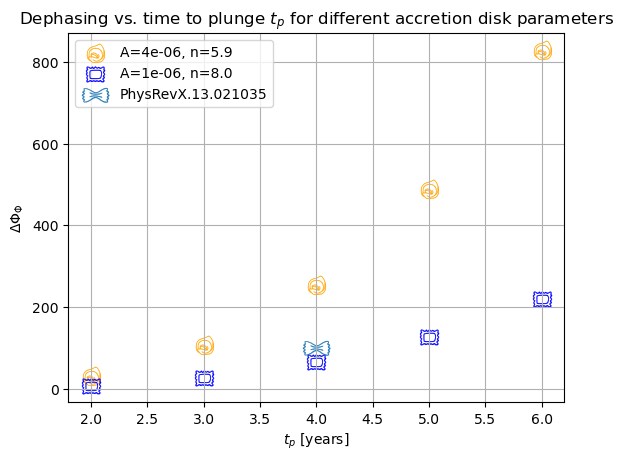

In [142]:
plt.title("Dephasing vs. time to plunge $t_p$ for different accretion disk parameters")
plt.scatter(
    results["orange"][:, 0],
    results["orange"][:, 1],
    color="orange",
    marker=markers.tortellini,
    label=results["orange"][:, 3][2],
    s=200,
    linewidth=0.2,
)
plt.scatter(
    results["blue"][:, 0],
    results["blue"][:, 1],
    color="blue",
    marker=markers.ravioli,
    label=results["blue"][:, 3][2],
    s=200,
    linewidth=0.2,
)
# plt.ylim(1e-3, 1e6)
plt.ylabel(r"$\Delta \Phi_{\Phi}$")
plt.xlabel("$t_p$ [years]")
plt.grid()
# Import values from https://dx.doi.org/10.1103/PhysRevX.13.021035 fig 1
plt.scatter(
    4,
    1e2,
    marker=markers.farfalle,
    label="PhysRevX.13.021035",
    s=400,
    linewidth=0.2,
)
plt.legend()
plt.show()

The dephasing $\Delta \Phi_{\Phi}$ obtained from the difference between the final orbital phase of an evolution with and without migration torques in $\alpha-$  or $\beta-$ accretion disks. For $\alpha-$disks, the slope is expected to be $n=8$, for $\beta-$ disks, $n=59/10$. The obtained value in previous work for $t_p=4 yr$ is shown in the Figure as a tortellino (see fig 1 of [PhysRevX.13.021035](https://dx.doi.org/10.1103/PhysRevX.13.021035))

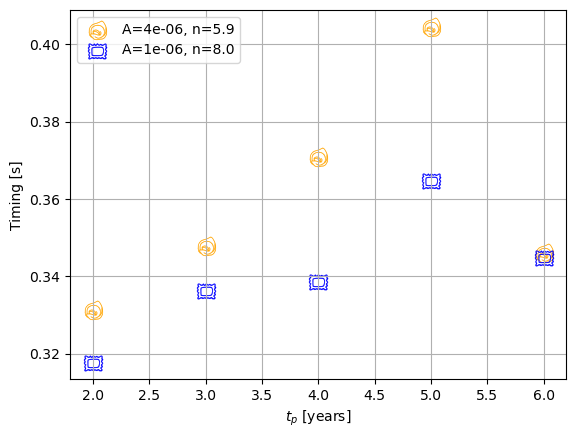

In [143]:
plt.scatter(
    results["orange"][:, 0],
    results["orange"][:, -1],
    color="orange",
    marker=markers.tortellini,
    label=results["orange"][:, 3][2],
    s=200,
    linewidth=0.2,
)
plt.scatter(
    results["blue"][:, 0],
    results["blue"][:, -1],
    color="blue",
    marker=markers.ravioli,
    label=results["blue"][:, 3][2],
    s=200,
    linewidth=0.2,
)
# plt.ylim(1e-3, 1e6)
plt.ylabel("Timing [s]")
plt.xlabel("$t_p$ [years]")
plt.grid()
plt.legend()
plt.show()